In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import tensorflow as tf

In [152]:
import os
os.environ["PATH"] += os.pathsep + '/Library/TeX/texbin'

In [153]:
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 8})# TeX rendering

In [27]:
import numpy as np
import keras
from keras import ops
from keras import layers
import pandas as pd
import matplotlib.pyplot as plt
from livelossplot import PlotLossesKeras
from scipy.optimize import minimize
import multiprocess as mp
from functools import partial

In [92]:
def parallelize(data, func, num_of_processes=8):
    data_split = np.array_split(data, num_of_processes)
    pool = mp.get_context('spawn').Pool(num_of_processes)
    data = pd.concat(pool.map(run_on_subset, data_split))
    pool.close()
    pool.join()
    return data

def run_on_subset(data_subset):
    import os
    os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
    import tensorflow as tf
    import numpy as np
    import keras
    from keras import ops
    from keras import layers
    import pandas as pd
    import matplotlib.pyplot as plt
    from livelossplot import PlotLossesKeras
    from scipy.optimize import minimize
    import multiprocess as mp
    from functools import partial

    @keras.saving.register_keras_serializable()
    class Sampling(layers.Layer):

        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            self.seed_generator = keras.random.SeedGenerator(1337)

        def call(self, inputs):
            z_mean, z_log_var = inputs
            batch = ops.shape(z_mean)[0]
            dim = ops.shape(z_mean)[1]
            epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
            return z_mean + ops.exp(0.5 * z_log_var) * epsilon

    @keras.saving.register_keras_serializable()
    class VAE(keras.Model):
        def __init__(self, **kwargs):
            super().__init__(**kwargs)
            self.encoder = self.gen_encoder()
            self.decoder = self.gen_decoder()
            self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
            self.reconstruction_loss_tracker = keras.metrics.Mean(
                name="reconstruction_loss"
            )
            self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

        @property
        def metrics(self):
            return [
                self.total_loss_tracker,
                self.reconstruction_loss_tracker,
                self.kl_loss_tracker,
            ]

        def train_step(self, data):
            beta = 400*30
            with tf.GradientTape() as tape:
                z_mean, z_log_var, z = self.encoder(data)
                reconstruction = self.decoder(z)
                reconstruction_loss = tf.keras.losses.MeanSquaredError(reduction=None)(data, reconstruction)
                kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
                kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
                total_loss = (beta*reconstruction_loss + kl_loss)/(beta+1)
            grads = tape.gradient(total_loss, self.trainable_weights)
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
            self.total_loss_tracker.update_state(total_loss)
            self.reconstruction_loss_tracker.update_state(reconstruction_loss)
            self.kl_loss_tracker.update_state(kl_loss)
            return {
                "loss": self.total_loss_tracker.result(),
                "reconstruction_loss": self.reconstruction_loss_tracker.result(),
                "kl_loss": self.kl_loss_tracker.result(),
            }

        def gen_encoder(self):
            latent_dim = 4
            encoder_inputs = keras.Input(shape=(400,))
            x = layers.Dense(256, activation="relu")(encoder_inputs)
            x = layers.Dense(64, activation="relu")(x)
            x = layers.Dense(32, activation="relu")(x)
            z_mean = layers.Dense(latent_dim, name="z_mean")(x)
            z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
            z = Sampling()([z_mean, z_log_var])
            encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
            return encoder

        def gen_decoder(self):
            latent_dim = 4
            latent_inputs = keras.Input(shape=(latent_dim,))
            x = layers.Dense(32, activation="relu")(latent_inputs)
            x = layers.Dense(64, activation="relu")(x)
            x = layers.Dense(256, activation="relu")(x)
            decoder_outputs = layers.Dense(400, activation="softplus")(x)
            decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
            return decoder
        
    vae_local = keras.saving.load_model('model.keras')
    
    def calculate_one_mask(y, mask_n_inv, vae_local):

        if mask_n_inv != 400:
            mask_n = 400 - mask_n_inv
            x0 = np.full(mask_n, 0.3)
            mask = np.random.choice(400, mask_n, replace=False)

            def recon_loss(x):
                y_masked = y.copy()
                y_masked[mask] = x
                recon_z_mean_masked = vae_local.encoder.predict(y_masked.reshape(1,400), verbose=0)[0]
                y_hat_masked = vae_local.decoder.predict(recon_z_mean_masked, verbose=0)[0]

                return np.mean(np.square(y_hat_masked - y_masked))

            result = minimize(recon_loss, x0, method='BFGS', options={"eps":0.001, "disp":False, "maxiter":30}, tol=0.0001)

            y_hat_patch = y.copy()
            y_hat_patch[mask] = result.x
            status_vec = np.full(400, result.status)
            mask_vec = ~np.isin(np.arange(400), mask)

            recon_z_mean_masked = vae_local.encoder.predict(y_hat_patch.reshape(1,400), verbose=0)[0]
            y_hat_full = vae_local.decoder.predict(recon_z_mean_masked, verbose=0)[0]

        else:
            status_vec = np.full(400, -1)
            mask_vec = np.full(400, True)
            y_hat_patch = y
            recon_z_mean_masked = vae_local.encoder.predict(y.reshape(1,400), verbose=0)[0]
            y_hat_full = vae_local.decoder.predict(recon_z_mean_masked, verbose=0)[0]

        return pd.DataFrame(np.array([y_hat_patch, y_hat_full, mask_vec, status_vec]).T, columns=[f'{mask_n_inv}_sigma_patched', f'{mask_n_inv}_sigma_full', f'{mask_n_inv}_mask', f'{mask_n_inv}_status'])
    
    def full_process(s):
        m_s = s.copy()
        try:
            dfs = []
            for m_n in [10, 100, 350, 400]:
                dfs.append(calculate_one_mask(s['data'].copy(), m_n, vae_local))

            pd_concat = pd.concat(dfs, axis=1)
            pd_concat['date'] = s['date']
            pd_concat['sigma'] = s['data']
            pd_concat.to_csv(f"results/{s['date']}.csv", index=False)
            m_s['status'] = 'success'

        except Exception as e:
            print(e)
            m_s['status'] = 'error'

        return m_s
    
    return data_subset.apply(full_process, axis=1)

In [4]:
# Grid Range
log_tau_range = (np.log(30/365), np.log(1))
log_m_range = (np.log(0.6), np.log(1.4))

# Grid Number of Points
tau_n_points = 20
m_n_points = 20

# Grid Vector Alternative
log_tau_grid_vec = np.linspace(log_tau_range[0], log_tau_range[1], tau_n_points)
log_m_grid_vec = np.linspace(log_m_range[0], log_m_range[1], m_n_points)

log_tau_vec = np.tile(log_tau_grid_vec, 20)
log_m_vec = log_m_grid_vec.repeat(20)

# Load Data

In [6]:
dataset = tf.data.Dataset.load('dataset_new.tfrecord')

# Model

In [7]:
@keras.saving.register_keras_serializable()
class Sampling(layers.Layer):

    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.seed_generator = keras.random.SeedGenerator(1337)

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = ops.shape(z_mean)[0]
        dim = ops.shape(z_mean)[1]
        epsilon = keras.random.normal(shape=(batch, dim), seed=self.seed_generator)
        return z_mean + ops.exp(0.5 * z_log_var) * epsilon

In [8]:
@keras.saving.register_keras_serializable()
class VAE(keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder = self.gen_encoder()
        self.decoder = self.gen_decoder()
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        beta = 400*30
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.keras.losses.MeanSquaredError(reduction=None)(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - ops.square(z_mean) - ops.exp(z_log_var))
            kl_loss = ops.mean(ops.sum(kl_loss, axis=1))
            total_loss = (beta*reconstruction_loss + kl_loss)/(beta+1)
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }
    
    def gen_encoder(self):
        latent_dim = 4
        encoder_inputs = keras.Input(shape=(400,))
        x = layers.Dense(256, activation="relu")(encoder_inputs)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(32, activation="relu")(x)
        z_mean = layers.Dense(latent_dim, name="z_mean")(x)
        z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
        z = Sampling()([z_mean, z_log_var])
        encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
        return encoder
    
    def gen_decoder(self):
        latent_dim = 4
        latent_inputs = keras.Input(shape=(latent_dim,))
        x = layers.Dense(32, activation="relu")(latent_inputs)
        x = layers.Dense(64, activation="relu")(x)
        x = layers.Dense(256, activation="relu")(x)
        decoder_outputs = layers.Dense(400, activation="softplus")(x)
        decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
        return decoder

In [33]:
vae = VAE()

In [9]:
def date_filter_train(date):
    date_p = pd.to_datetime(date.numpy().decode('utf-8'))
    return date_p < pd.to_datetime('01-01-2013')

In [10]:
def date_filter_test(date):
    date_p = pd.to_datetime(date.numpy().decode('utf-8'))
    return date_p >= pd.to_datetime('01-01-2013')

In [11]:
dataset_map_train = dataset.map(lambda *x: (*x, tf.py_function(date_filter_train, [x[1]], [tf.bool])))
dataset_train = dataset_map_train.filter(lambda *x: x[7])

In [12]:
dataset_map_test = dataset.map(lambda *x: (*x, tf.py_function(date_filter_test, [x[1]], [tf.bool])))
dataset_test = dataset_map_test.filter(lambda *x: x[7])

In [13]:
ds_mapped = dataset_train.map(lambda *x: tf.reshape(x[0], [400]))
ds_cached = ds_mapped.cache()
ds_shuffled = ds_cached.shuffle(5000, reshuffle_each_iteration=True, seed=243)

In [14]:
ds_mapped_test = dataset_test.map(lambda *x: tf.reshape(x[0], [400]))
ds_cached_test = ds_mapped_test.cache()

In [40]:
#ds_test = ds_shuffled.take(5).cache()

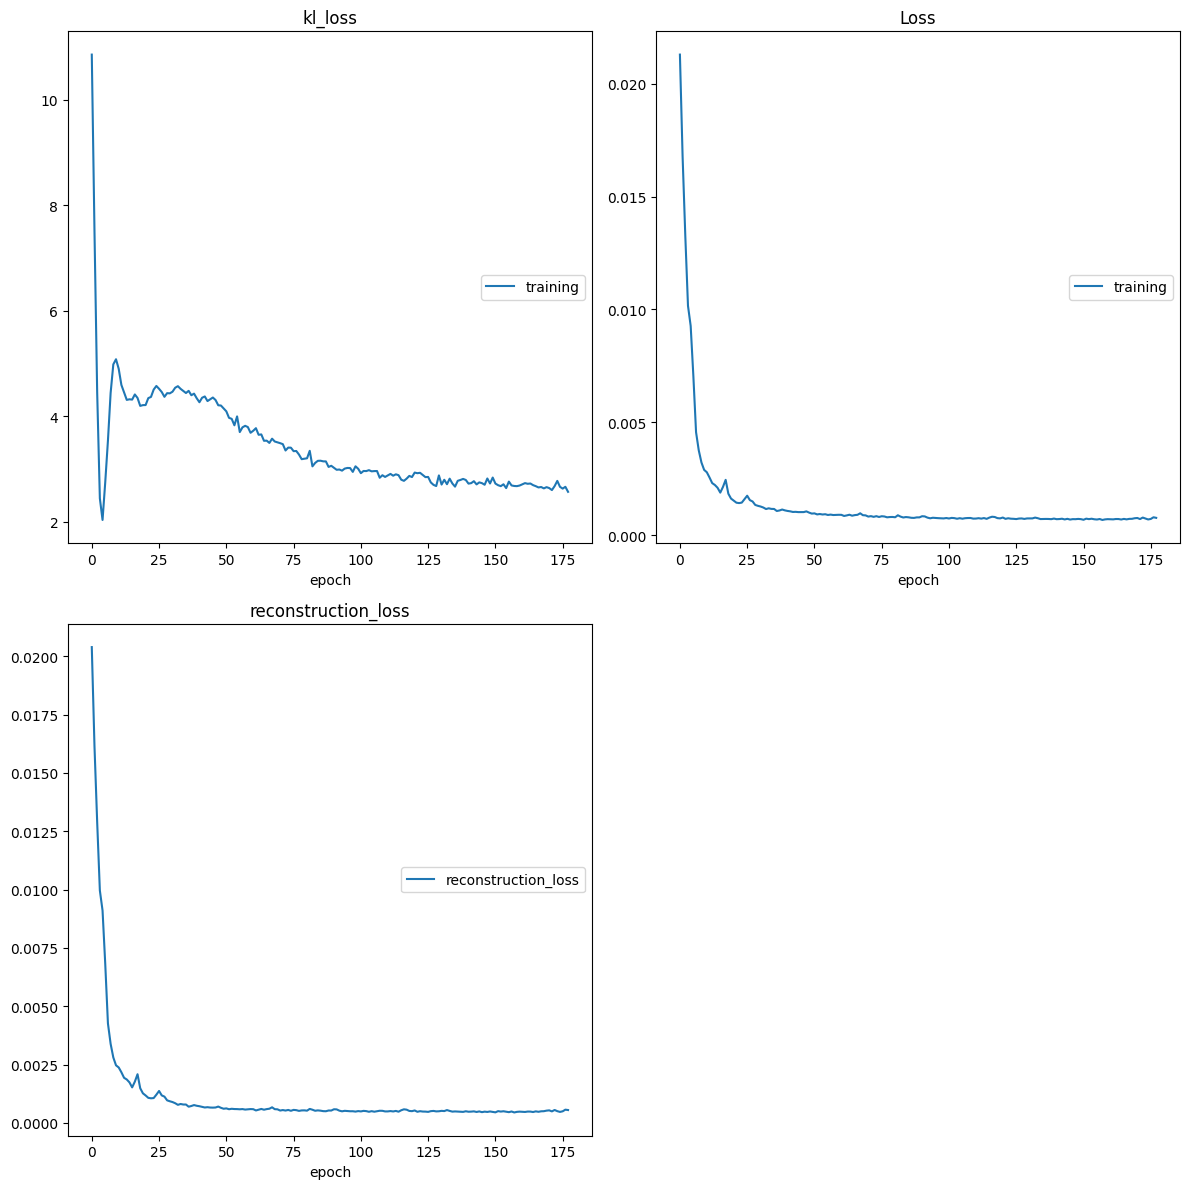

kl_loss
	training         	 (min:    2.030, max:   10.852, cur:    2.563)
Loss
	training         	 (min:    0.001, max:    0.021, cur:    0.001)
reconstruction_loss
	reconstruction_loss 	 (min:    0.000, max:    0.020, cur:    0.001)


In [42]:
callback_stop = keras.callbacks.EarlyStopping(monitor="loss", patience=20, restore_best_weights=True)

batch_size = 64
epochs = 200
ds_repeated = ds_shuffled.repeat(epochs)
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss="total_loss")
history = vae.fit(ds_repeated.batch(batch_size), epochs=epochs, steps_per_epoch=len(list(ds_shuffled))//batch_size,
          callbacks=[PlotLossesKeras(), callback_stop],
          verbose=0)

In [43]:
vae.save('model.keras')

In [18]:
history.history['reconstruction_loss'][-1]

0.0005274613504298031

In [1298]:
history.history['reconstruction_loss'][-1]

0.0003544040664564818

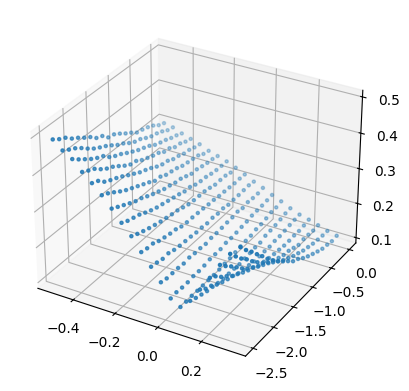

In [19]:
x = vae.decoder.predict(np.array([[0, 0, 0, 0]]), verbose=0)[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, x, s=5)
plt.show()

## Actual

In [20]:
y = np.asarray(list(ds_cached_test.shuffle(5000).take(1)))[0:1]

2024-05-12 18:33:52.758659: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


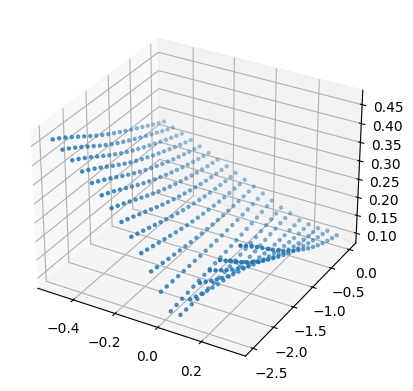

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, y, s=5)
plt.show()

In [22]:
z_hat = vae.encoder.predict(y, verbose=0)[0]

In [23]:
z_hat

array([[ 0.33858025,  0.04900426,  0.0201212 , -0.20591672]],
      dtype=float32)

## Reconstructed

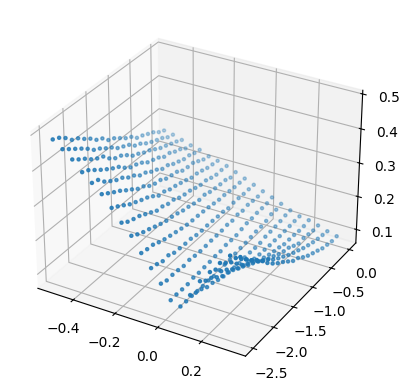

In [24]:
x = vae.decoder.predict(z_hat, verbose=0)[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, x, s=5)
plt.show()

In [25]:
np.sqrt(np.mean(np.square(x - y)))

0.010371121

In [26]:
np.mean(np.abs(x - y))

0.007445612

# Sample

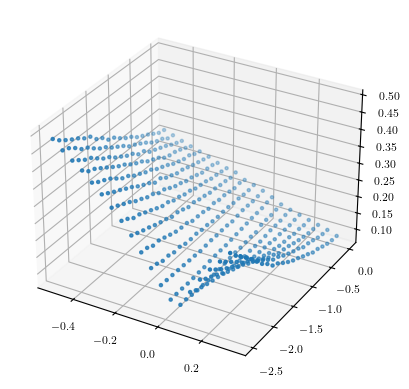

In [405]:
x = vae_1.decoder.predict(np.array([[-0.5,-0.5,0.5,0]]), verbose=0)[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, x, s=5)
plt.show()

# Missing Data

In [1242]:
y = np.asarray(list(ds_cached_test.shuffle(5000).take(1)))[0:1]

2024-05-12 18:17:19.665058: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


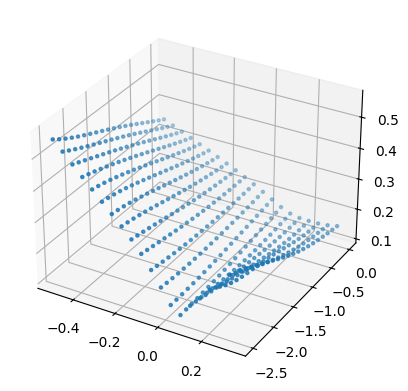

In [1243]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, y, s=5)
plt.show()

In [1246]:
mask = np.random.choice(400, 100,replace=False)
y_masked = y.copy()
y_masked[:, mask] = 0

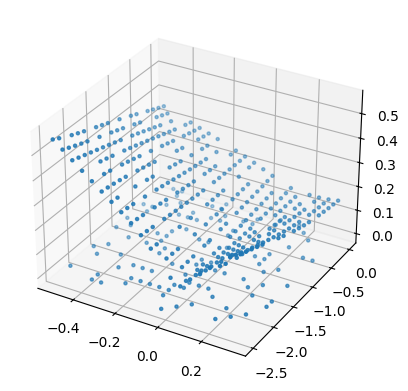

In [1247]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, y_masked, s=5)
plt.show()

In [1248]:
recon_z_mean = vae.encoder.predict(y, verbose=0)[0]
recon_z_mean_masked = vae.encoder.predict(y_masked, verbose=0)[0]

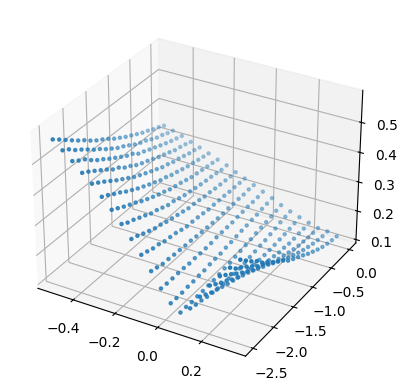

In [1249]:
x = vae.decoder.predict(recon_z_mean, verbose=0)[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, x, s=5)
plt.show()

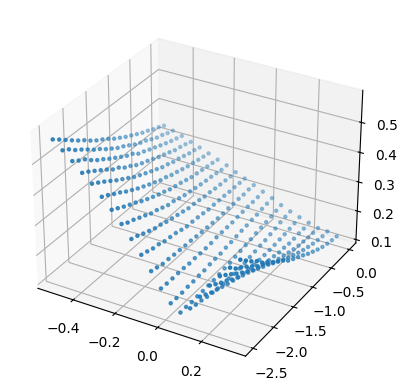

In [1250]:
x_masked = vae.decoder.predict(recon_z_mean_masked, verbose=0)[0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, x, s=5)
plt.show()

In [1251]:
np.mean(np.abs(x - x_masked))

0.058545817

### Guess

In [114]:
x0 = list(np.full(100, 0.3))

In [115]:
mask = np.random.choice(400, 100,replace=False)

In [116]:
def recon_loss(x):
    y_masked = y.copy()
    y_masked[:, mask] = x
    recon_z_mean_masked = vae.encoder.predict(y_masked, verbose=0)[0]
    y_hat_masked = vae.decoder.predict(recon_z_mean_masked, verbose=0)[0]
    
    return np.mean(np.square(y_hat_masked - y_masked))

In [117]:
def evaluate(x):
    y_masked = y.copy()
    y_masked[:, mask] = x
    return np.mean(np.square(y_masked - y))

In [118]:
def evaluate_reconstruct(x):
    y_masked = y.copy()
    y_masked[:, mask] = x
    recon_z_mean_masked = vae.encoder.predict(y_masked, verbose=0)[0]
    y_hat_masked = vae.decoder.predict(recon_z_mean_masked, verbose=0)[0]
    return np.mean(np.square(y_hat_masked - y))

In [1258]:
result = minimize(recon_loss, x0, method='BFGS', options={"eps":0.001, "disp":True, "maxiter":15}, tol=0.0001)

Optimization terminated successfully.
         Current function value: 0.000129
         Iterations: 8
         Function evaluations: 1313
         Gradient evaluations: 13


In [1259]:
result

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 0.00012865714
        x: [ 3.572e-01  4.472e-01 ...  1.257e-01  4.644e-01]
      nit: 8
      jac: [-2.547e-06 -2.545e-05 ...  5.995e-06 -3.123e-05]
 hess_inv: [[ 2.245e+00  1.200e+00 ... -4.549e-01  1.785e+00]
            [ 1.200e+00  3.008e+00 ... -1.859e+00  2.478e+00]
            ...
            [-4.549e-01 -1.859e+00 ...  3.536e+00 -1.917e+00]
            [ 1.785e+00  2.478e+00 ... -1.917e+00  4.234e+00]]
     nfev: 1313
     njev: 13

In [1260]:
evaluate(result.x)

4.754406e-05

In [1261]:
evaluate_reconstruct(result.x)

0.00016654603

In [1262]:
y_masked_hat = y.copy()
y_masked_hat[:, mask] = result.x

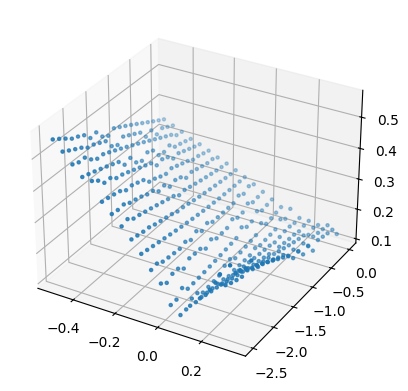

In [1263]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, y_masked_hat, s=5)
plt.show()

In [1264]:
recon_z_mean_masked = vae.encoder.predict(y_masked, verbose=0)[0]
y_hat_masked = vae.decoder.predict(recon_z_mean_masked, verbose=0)[0]

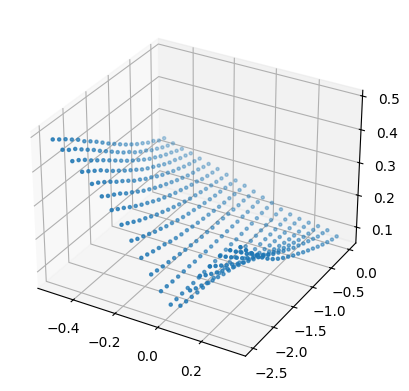

In [1265]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, y_hat_masked, s=5)
plt.show()

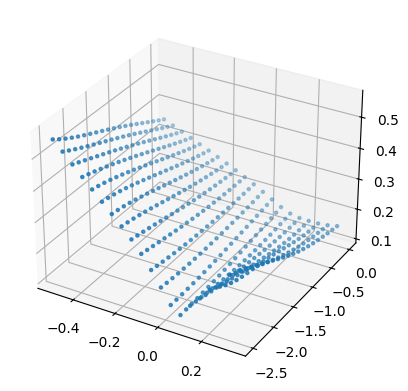

In [1266]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, y, s=5)
plt.show()

# Benchmarking

In [135]:
from matplotlib import cm

In [15]:
ds_test = dataset_test.cache()

In [16]:
df = pd.DataFrame(ds_test.map(lambda *x: x[0:5]).as_numpy_iterator(), columns=['data', 'date', 'mask_10', 'mask_100', 'mask_350'])

2024-05-12 20:13:50.239070: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [17]:
df['date'] = df['date'].str.decode('utf-8')

In [18]:
s = df.iloc[-1]

In [293]:
vs = df['data'].values

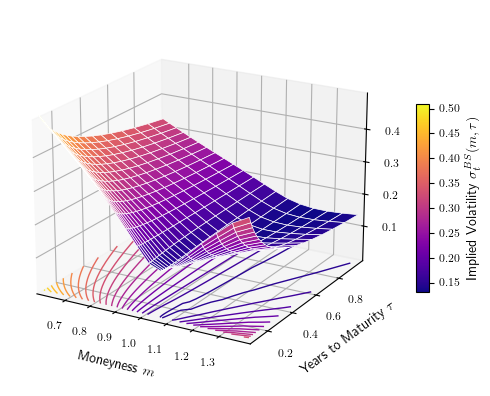

In [ ]:
fig = plt.figure(figsize=(6.3, 4))

X = np.exp(log_m_vec.reshape(20,20))
Y = np.exp(log_tau_vec.reshape(20,20))
Z = vs.mean().reshape(20,20)

ax = fig.add_subplot(111, projection='3d')
surf = ax.plot_surface(X, Y, Z, cmap=cm.plasma, linewidths=0.5, edgecolor='white')
ax.contour(X, Y, Z, 20, zdir='z', offset=0, cmap=cm.plasma, linewidths=1)

ax.set_xlim3d(X[0][0]+0.001, X[-1][0]-0.001)
ax.set_ylim3d(Y[0][0]+0.001, Y[0][-1]-0.001)
ax.set_zlim3d(0+0.001, 0.5-0.001)

ax.set_xlabel(r'Moneyness $m$', fontsize=10)
ax.set_ylabel(r'Years to Maturity $\tau$', fontsize=10)

cbar = fig.colorbar(surf, shrink=0.5, aspect=15)
cbar.ax.set_ylabel(r'Implied Volatility $\sigma^{BS}_t(m, \tau)$', fontsize=10)
ax.view_init(elev=20, azim=-60, roll=0)
plt.tight_layout()
plt.show()

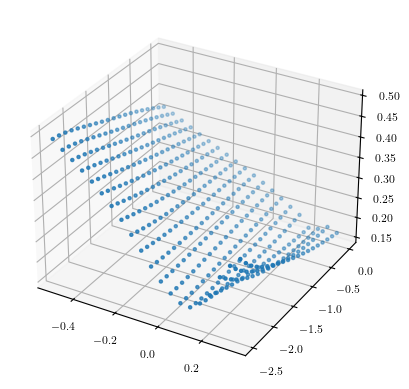

In [285]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(log_m_vec, log_tau_vec, s['data'], s=5)
plt.show()

In [ ]:
y = s['data'].copy()
mask_n = 50

x0 = np.full(mask_n, 0.3)
mask = np.random.choice(400, mask_n, replace=False)

def recon_loss(x):
    y_masked = y.copy()
    y_masked[mask] = x
    recon_z_mean_masked = vae.encoder.predict(y_masked.reshape(1,400), verbose=0)[0]
    y_hat_masked = vae.decoder.predict(recon_z_mean_masked, verbose=0)[0]
    
    return np.mean(np.square(y_hat_masked - y_masked))

result = minimize(recon_loss, x0, method='BFGS', options={"eps":0.001, "disp":False, "maxiter":20}, tol=0.0001)

y_hat_patch = y.copy()
y_hat_patch[mask] = result.x
status_vec = np.full(400, result.status)
mask_vec = ~np.isin(np.arange(400), mask)

recon_z_mean_masked = vae.encoder.predict(y_masked.reshape(1,400), verbose=0)[0]
y_hat_full = vae.decoder.predict(recon_z_mean_masked, verbose=0)[0]

result_df = pd.DataFrame(np.array([y_hat_patch, y_hat_full, mask_vec, status_vec]).T, columns=[f'{mask_n_inv}_sigma_patched', f'{mask_n_inv}_sigma_full', f'{mask_n_inv}_mask', f'{mask_n_inv}_status'])

In [21]:
def calculate_one_mask(y, mask_n_inv, vae_local):
    
    if mask_n_inv != 400:
        mask_n = 400 - mask_n_inv
        x0 = np.full(mask_n, 0.3)
        mask = np.random.choice(400, mask_n, replace=False)

        def recon_loss(x):
            y_masked = y.copy()
            y_masked[mask] = x
            recon_z_mean_masked = vae_local.encoder.predict(y_masked.reshape(1,400), verbose=0)[0]
            y_hat_masked = vae_local.decoder.predict(recon_z_mean_masked, verbose=0)[0]

            return np.mean(np.square(y_hat_masked - y_masked))

        result = minimize(recon_loss, x0, method='BFGS', options={"eps":0.001, "disp":False, "maxiter":30}, tol=0.0001)

        y_hat_patch = y.copy()
        y_hat_patch[mask] = result.x
        status_vec = np.full(400, result.status)
        mask_vec = ~np.isin(np.arange(400), mask)

        recon_z_mean_masked = vae_local.encoder.predict(y_masked.reshape(1,400), verbose=0)[0]
        y_hat_full = vae_local.decoder.predict(recon_z_mean_masked, verbose=0)[0]
    
    else:
        status_vec = np.full(400, -1)
        mask_vec = np.full(400, True)
        y_hat_patch = y
        recon_z_mean_masked = vae_local.encoder.predict(y.reshape(1,400), verbose=0)[0]
        y_hat_full = vae_local.decoder.predict(recon_z_mean_masked, verbose=0)[0]

    return pd.DataFrame(np.array([y_hat_patch, y_hat_full, mask_vec, status_vec]).T, columns=[f'{mask_n_inv}_sigma_patched', f'{mask_n_inv}_sigma_full', f'{mask_n_inv}_mask', f'{mask_n_inv}_status'])

In [52]:
def full_process(s, vae_local):
    m_s = s.copy()
    try:
        dfs = []
        for m_n in [350, 400]:
            dfs.append(calculate_one_mask(s['data'].copy(), m_n, vae_local))
        
        pd_concat = pd.concat(dfs, axis=1)
        pd_concat['date'] = s['date']
        pd_concat['sigma'] = s['data']
        pd_concat.to_csv(f"results/{s['date']}.csv")
        m_s['status'] = 'success'
            
    except Exception as e:
        print(e)
        m_s['status'] = 'error'
        
    return m_s

In [53]:
vae_1 = keras.saving.load_model('model.keras')

/Users/timschlegel/miniconda3/envs/tensorflow/lib/python3.9/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 38 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [54]:
%timeit -r 1 -n 1 full_process(s, vae_1)

name 'y_masked' is not defined
27.2 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [ ]:
parallelize(df_sub, full_process)